# Feature: Out-Of-Fold Predictions from a Bidirectional LSTM (+Magic Inputs)

In addition to the bidirectional LSTM architecture, we'll append some of the leaky features to the intermediate feature layer.

<img src="assets/bi-lstm-with-magic.png" alt="Network Architecture" style="height: 700px;" />

## Imports

This utility package imports `numpy`, `pandas`, `matplotlib` and a helper `kg` module into the root namespace.

In [1]:
from pygoose import *

In [2]:
import gc

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import *

In [5]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


## Config

Automatically discover the paths to various data folders and compose the project structure.

In [6]:
project = kg.Project.discover()

Identifier for storing these features on disk and referring to them later.

In [7]:
feature_list_id = 'oofp_nn_bi_lstm_with_magic'

Make subsequent NN runs reproducible.

In [8]:
RANDOM_SEED = 42

In [9]:
np.random.seed(RANDOM_SEED)

## Read data

Word embedding lookup matrix.

In [10]:
embedding_matrix = kg.io.load(project.aux_dir + 'fasttext_vocab_embedding_matrix.pickle')

Padded sequences of word indices for every question.

In [11]:
X_train_q1 = kg.io.load(project.preprocessed_data_dir + 'sequences_q1_fasttext_train.pickle')
X_train_q2 = kg.io.load(project.preprocessed_data_dir + 'sequences_q2_fasttext_train.pickle')

In [12]:
X_test_q1 = kg.io.load(project.preprocessed_data_dir + 'sequences_q1_fasttext_test.pickle')
X_test_q2 = kg.io.load(project.preprocessed_data_dir + 'sequences_q2_fasttext_test.pickle')

In [13]:
y_train = kg.io.load(project.features_dir + 'y_train.pickle')

Magic features.

In [14]:
magic_feature_lists = [
    'magic_frequencies',
    'magic_cooccurrence_matrix',
]

In [15]:
X_train_magic, X_test_magic, _ = project.load_feature_lists(magic_feature_lists)

In [16]:
X_train_magic = X_train_magic.values
X_test_magic = X_test_magic.values

In [17]:
scaler = StandardScaler()
scaler.fit(np.vstack([X_train_magic, X_test_magic]))
X_train_magic = scaler.transform(X_train_magic)
X_test_magic = scaler.transform(X_test_magic)

Word embedding properties.

In [18]:
EMBEDDING_DIM = embedding_matrix.shape[-1]
VOCAB_LENGTH = embedding_matrix.shape[0]
MAX_SEQUENCE_LENGTH = X_train_q1.shape[-1]

In [19]:
print(EMBEDDING_DIM, VOCAB_LENGTH, MAX_SEQUENCE_LENGTH)

300 101564 30


## Define models

In [20]:
def create_model_question_branch():
    input_q = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    
    embedding_q = Embedding(
        VOCAB_LENGTH,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False,
    )(input_q)

    timedist_q = TimeDistributed(Dense(
        EMBEDDING_DIM,
        activation='relu',
    ))(embedding_q)

    lambda_q = Lambda(
        lambda x: K.max(x, axis=1),
        output_shape=(EMBEDDING_DIM, )
    )(timedist_q)
    
    output_q = lambda_q
    return input_q, output_q

In [21]:
def create_model(params):    
    embedding_layer = Embedding(
        VOCAB_LENGTH,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False,
    )
    lstm_layer = Bidirectional(LSTM(
        params['num_lstm'],
        dropout=params['lstm_dropout_rate'],
        recurrent_dropout=params['lstm_dropout_rate'],
    ))

    sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    x1 = lstm_layer(embedded_sequences_1)

    sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_2 = embedding_layer(sequence_2_input)
    y1 = lstm_layer(embedded_sequences_2)

    magic_input = Input(shape=(X_train_magic.shape[-1], ))
    
    merged = concatenate([x1, y1, magic_input])
    merged = Dropout(params['dense_dropout_rate'])(merged)
    merged = BatchNormalization()(merged)

    merged = Dense(params['num_dense'], activation='relu')(merged)
    merged = Dropout(params['dense_dropout_rate'])(merged)
    merged = BatchNormalization()(merged)

    output = Dense(1, activation='sigmoid')(merged)

    model = Model(
        inputs=[sequence_1_input, sequence_2_input, magic_input],
        outputs=output
    )

    model.compile(
        loss='binary_crossentropy',
        optimizer='nadam',
        metrics=['accuracy']
    )

    return model

In [22]:
def predict(model, X_q1, X_q2, X_magic):
    """
    Mirror the pairs, compute two separate predictions, and average them.
    """
    
    y1 = model.predict([X_q1, X_q2, X_magic], batch_size=1024, verbose=1).reshape(-1)   
    y2 = model.predict([X_q2, X_q1, X_magic], batch_size=1024, verbose=1).reshape(-1)    
    return (y1 + y2) / 2

## Partition the data

In [23]:
NUM_FOLDS = 5

In [24]:
kfold = StratifiedKFold(
    n_splits=NUM_FOLDS,
    shuffle=True,
    random_state=RANDOM_SEED
)

Create placeholders for out-of-fold predictions.

In [25]:
y_train_oofp = np.zeros_like(y_train, dtype='float64')

In [26]:
y_test_oofp = np.zeros((len(X_test_q1), NUM_FOLDS))

## Define hyperparameters

In [27]:
BATCH_SIZE = 2048

In [28]:
MAX_EPOCHS = 200

Best values picked by Bayesian optimization.

In [29]:
model_params = {
    'dense_dropout_rate': 0.075,
    'lstm_dropout_rate': 0.332,
    'num_dense': 130,
    'num_lstm': 300,
}

The path where the best weights of the current model will be saved.

In [30]:
model_checkpoint_path = project.temp_dir + 'fold-checkpoint-' + feature_list_id + '.h5'

## Fit the folds and compute out-of-fold predictions

In [31]:
%%time

# Iterate through folds.
for fold_num, (ix_train, ix_val) in enumerate(kfold.split(X_train_q1, y_train)):
    
    # Augment the training set by mirroring the pairs.
    X_fold_train_q1 = np.vstack([X_train_q1[ix_train], X_train_q2[ix_train]])
    X_fold_train_q2 = np.vstack([X_train_q2[ix_train], X_train_q1[ix_train]])
    X_fold_train_magic = np.vstack([X_train_magic[ix_train], X_train_magic[ix_train]])

    X_fold_val_q1 = np.vstack([X_train_q1[ix_val], X_train_q2[ix_val]])
    X_fold_val_q2 = np.vstack([X_train_q2[ix_val], X_train_q1[ix_val]])
    X_fold_val_magic = np.vstack([X_train_magic[ix_val], X_train_magic[ix_val]])

    # Ground truth should also be "mirrored".
    y_fold_train = np.concatenate([y_train[ix_train], y_train[ix_train]])
    y_fold_val = np.concatenate([y_train[ix_val], y_train[ix_val]])
    
    print()
    print(f'Fitting fold {fold_num + 1} of {kfold.n_splits}')
    print()
    
    # Compile a new model.
    model = create_model(model_params)

    # Train.
    model.fit(
        [X_fold_train_q1, X_fold_train_q2, X_fold_train_magic], y_fold_train,
        validation_data=([X_fold_val_q1, X_fold_val_q2, X_fold_val_magic], y_fold_val),

        batch_size=BATCH_SIZE,
        epochs=MAX_EPOCHS,
        verbose=1,
        
        callbacks=[
            # Stop training when the validation loss stops improving.
            EarlyStopping(
                monitor='val_loss',
                min_delta=0.001,
                patience=3,
                verbose=1,
                mode='auto',
            ),
            # Save the weights of the best epoch.
            ModelCheckpoint(
                model_checkpoint_path,
                monitor='val_loss',
                save_best_only=True,
                verbose=2,
            ),
        ],
    )
        
    # Restore the best epoch.
    model.load_weights(model_checkpoint_path)
    
    # Compute out-of-fold predictions.
    y_train_oofp[ix_val] = predict(model, X_train_q1[ix_val], X_train_q2[ix_val], X_train_magic[ix_val])
    y_test_oofp[:, fold_num] = predict(model, X_test_q1, X_test_q2, X_test_magic)
    
    # Clear GPU memory.
    K.clear_session()
    del X_fold_train_q1, X_fold_train_q2, X_fold_train_magic
    del X_fold_val_q1, X_fold_val_q2, X_fold_val_magic
    del model
    gc.collect()


Fitting fold 1 of 5

Train on 646862 samples, validate on 161718 samples
Epoch 1/200
646862/646862 [==============================] - 268s - loss: 0.4095 - acc: 0.8139 - val_loss: 0.3796 - val_acc: 0.8486
Epoch 2/200
646862/646862 [==============================] - 270s - loss: 0.3405 - acc: 0.8453 - val_loss: 0.3188 - val_acc: 0.8606
Epoch 3/200
646862/646862 [==============================] - 271s - loss: 0.3135 - acc: 0.8575 - val_loss: 0.2968 - val_acc: 0.8681
Epoch 4/200
646862/646862 [==============================] - 262s - loss: 0.2952 - acc: 0.8659 - val_loss: 0.2967 - val_acc: 0.8639
Epoch 5/200
646862/646862 [==============================] - 265s - loss: 0.2802 - acc: 0.8736 - val_loss: 0.2803 - val_acc: 0.8740
Epoch 6/200
646862/646862 [==============================] - 272s - loss: 0.2680 - acc: 0.8788 - val_loss: 0.2743 - val_acc: 0.8778
Epoch 7/200
646862/646862 [==============================] - 272s - loss: 0.2570 - acc: 0.8844 - val_loss: 0.2726 - val_acc: 0.8786
Ep

646864/646864 [==============================] - 260s - loss: 0.3414 - acc: 0.8453 - val_loss: 0.3311 - val_acc: 0.8583
Epoch 3/200
646864/646864 [==============================] - 266s - loss: 0.3130 - acc: 0.8583 - val_loss: 0.3042 - val_acc: 0.8633
Epoch 4/200
646864/646864 [==============================] - 254s - loss: 0.2943 - acc: 0.8667 - val_loss: 0.3059 - val_acc: 0.8588
Epoch 5/200
646864/646864 [==============================] - 260s - loss: 0.2799 - acc: 0.8738 - val_loss: 0.2827 - val_acc: 0.8721
Epoch 6/200
646864/646864 [==============================] - 267s - loss: 0.2683 - acc: 0.8789 - val_loss: 0.2796 - val_acc: 0.8727
Epoch 7/200
646864/646864 [==============================] - 274s - loss: 0.2577 - acc: 0.8844 - val_loss: 0.2724 - val_acc: 0.8775
Epoch 8/200
646864/646864 [==============================] - 271s - loss: 0.2478 - acc: 0.8895 - val_loss: 0.2925 - val_acc: 0.8657
Epoch 9/200
646864/646864 [==============================] - 273s - loss: 0.2392 - acc: 

646866/646866 [==============================] - 261s - loss: 0.3414 - acc: 0.8454 - val_loss: 0.3349 - val_acc: 0.8516
Epoch 3/200
646866/646866 [==============================] - 261s - loss: 0.3137 - acc: 0.8581 - val_loss: 0.2946 - val_acc: 0.8681
Epoch 4/200
646866/646866 [==============================] - 265s - loss: 0.2952 - acc: 0.8661 - val_loss: 0.2850 - val_acc: 0.8728
Epoch 5/200
646866/646866 [==============================] - 262s - loss: 0.2806 - acc: 0.8731 - val_loss: 0.2826 - val_acc: 0.8732
Epoch 6/200
646866/646866 [==============================] - 262s - loss: 0.2687 - acc: 0.8784 - val_loss: 0.2800 - val_acc: 0.8731
Epoch 7/200
646866/646866 [==============================] - 262s - loss: 0.2578 - acc: 0.8842 - val_loss: 0.2880 - val_acc: 0.8682
Epoch 8/200
646866/646866 [==============================] - 262s - loss: 0.2490 - acc: 0.8882 - val_loss: 0.2732 - val_acc: 0.8773
Epoch 9/200
646866/646866 [==============================] - 266s - loss: 0.2393 - acc: 

In [32]:
cv_score = log_loss(y_train, y_train_oofp)
print('CV score:', cv_score)

CV score: 0.271838110004


## Save features

In [33]:
feature_names = [feature_list_id]

In [34]:
features_train = y_train_oofp.reshape((-1, 1))

In [35]:
features_test = np.mean(y_test_oofp, axis=1).reshape((-1, 1))

In [36]:
project.save_features(features_train, features_test, feature_names, feature_list_id)

## Explore

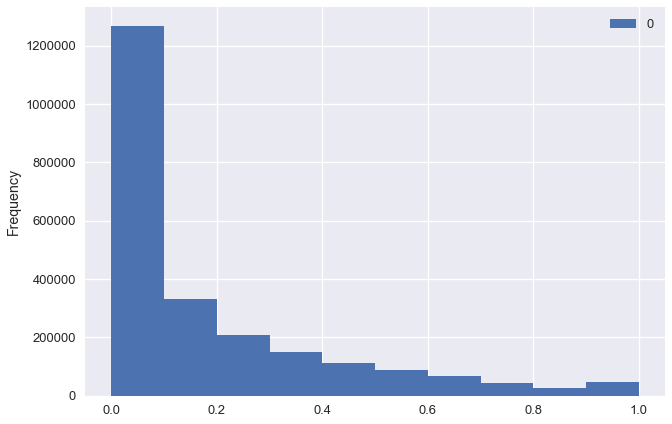

In [37]:
pd.DataFrame(features_test).plot.hist()